# 使用dask.delayed并行化代码

使用Dask.delayed并行化简单的for循环代码。通常，这是需要转换用于Dask的函数的惟一函数。

这是一种使用dask并行化现有代码库或构建复杂系统的简单方法。

**Related Documentation**

* [Delayed documentation](https://docs.dask.org/en/latest/delayed.html)
* [Delayed screencast](https://www.youtube.com/watch?v=SHqFmynRxVU)
* [Delayed API](https://docs.dask.org/en/latest/delayed-api.html)
* [Delayed examples](https://examples.dask.org/delayed.html)
* [Delayed best practices](https://docs.dask.org/en/latest/delayed-best-practices.html)

Dask有几种并行执行代码的方法。接下来将通过创建dask.distributed.Client来使用分布式调度器。这能为我们提供一些很好的诊断。后续再详细讨论调度器。

In [1]:
from dask.distributed import Client

client = Client()
client

Client Scheduler: tcp://127.0.0.1:1078 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 8.45 GB


In [22]:
print(client)

<Client: 'tcp://127.0.0.1:1078' processes=4 threads=8, memory=8.45 GB>


因为本repo environment下面已经安装了Bokeh，所以可以打开上面Dashboard给出的网址，查看 diagnostic dashboard 

diagnostic dashboard 的说明可以参考这里： https://docs.dask.org/en/latest/diagnostics-distributed.html

## 基础

一个简单例子，inc和add函数，sleep一会以模拟工作。

In [2]:
from time import sleep

def inc(x):
    sleep(1)
    return x + 1

def add(x, y):
    sleep(1)
    return x + y

使用 %%time 计时代码的执行时间

In [3]:
%%time
# This takes three seconds to run because we call each
# function sequentially, one after the other

x = inc(1)
y = inc(2)
z = add(x, y)

Wall time: 3.02 s


### 使用dask.delayed装饰器并行化

这两个inc调用可以并行，因为它们彼此完全独立。

使用dask.delayed函数转换inc和add函数。当我们传递参数调用delayed版本时，函数实际上还没有被调用-这就是为什么单元格执行完成得非常快的原因。相反，创建一个delayed对象，来跟踪要调用的函数和要传递给它的参数。

In [4]:
from dask import delayed

In [5]:
%%time
# This runs immediately, all it does is build a graph

x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x, y)

Wall time: 20 ms


这很快就结束了，因为还没有真正执行什么。

要获得结果，需要调用compute。注意，这比原始代码运行得快。

In [6]:
%%time
# This actually runs our computation using a local thread pool

z.compute()

Wall time: 2.09 s


5

## 刚才发生了什么?

z对象是一个delayed对象。该对象包含计算最终结果所需的所有内容，包括对所有所需函数的引用、它们的输入以及彼此之间的关系。可以像上面那样使用.compute()计算结果，也可以使用.visualize()可视化该值的任务图。

In [7]:
z

Delayed('add-657366d1-c6e5-4f2d-a063-8f9a2e7ae639')

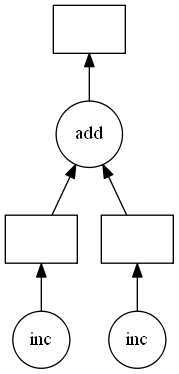

In [8]:
# Look at the task graph for `z`
z.visualize()

注意，这包括前面提到的函数名，以及inc函数输出到add输入的逻辑流。

在 diagnostic dashboard 上每行对应一个thread，，可以看到，两个inc分布在两行，执行完之后，执行了add，总共花费1+1.01 s

### 需要考虑的一些问题

- 为什么从3s到2s?为什么不能并行化到1s呢?
- 如果inc和add函数没有包含sleep(1)会发生什么?dask还能加速这段代码吗?
- 如果有多个输出，或者也想访问x或y呢?

## 并行化for循环

For循环是最常见的想要并行化的东西之一。使用dask.delayed on inc和sum来并行化下面的计算:

In [9]:
data = [1, 2, 3, 4, 5, 6, 7, 8]

In [10]:
%%time
# Sequential code

results = []
for x in data:
    y = inc(x)
    results.append(y)
    
total = sum(results)

Wall time: 8.05 s


In [11]:
total

44

In [12]:
%%time
results = []

for x in data:
    y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)
print("Before computing:", total)  # Let's see what type of thing total is
result = total.compute()
print("After computing :", result)  # After it's computed

Before computing: Delayed('sum-f2a6837d-2c7f-487c-b0f1-7b2000e12c30')
After computing : 44
Wall time: 1.09 s


## Exercise: 将for循环代码与控制流并行化

通常我们只想delay一部分函数，立即运行另一些函数。当这些函数速度很快时，这一点特别有用，可以帮助我们确定应该调用哪些其他速度较慢的函数。在使用dask.delayed时，通常需要考虑延迟或不延迟的决定。

在下面的例子中，遍历一个输入列表。如果输入是偶数，则调用inc。如果输入是奇数，那么要调用double。为了继续我们的图形构建Python代码，必须立即(而不是延迟)做出调用inc或double的is_even决定。

In [13]:
def double(x):
    sleep(1)
    return 2 * x

def is_even(x):
    return not x % 2

data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [14]:
%%time
# Sequential code

results = []
for x in data:
    if is_even(x):
        y = double(x)
    else:
        y = inc(x)
    results.append(y)
    
total = sum(results)
print(total)

90
Wall time: 10.1 s


In [15]:
results = []
for x in data:
    # 判断的语句是需要立即做出决定的
    if is_even(x):  # even
        y = delayed(double)(x)
    else:          # odd
        y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)

In [16]:
%time total.compute()

Wall time: 2.05 s


90

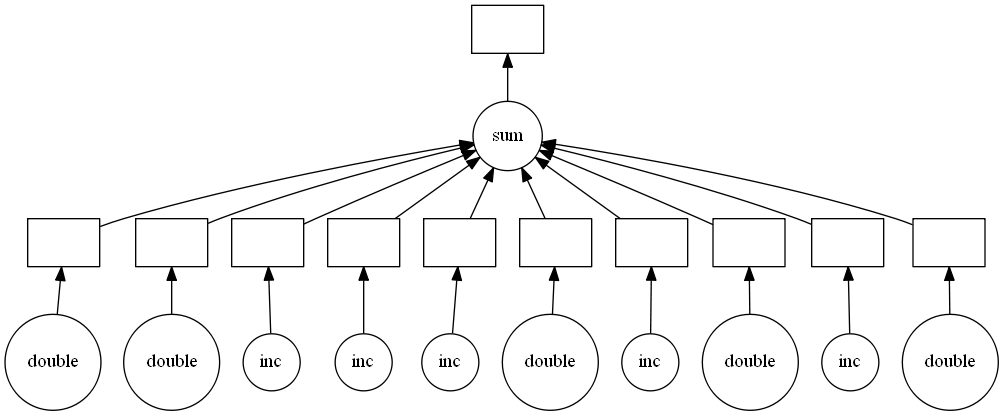

In [15]:
total.visualize()

如果不求和，也是可以直接对list执行delayed计算的，一样的。

In [19]:
results = []
for x in data:
    # 判断的语句是需要立即做出决定的
    if is_even(x):  # even
        y = delayed(double)(x)
    else:          # odd
        y = delayed(inc)(x)
    results.append(y)

In [21]:
%time delayed(results).compute()

Wall time: 2.05 s


[2, 4, 4, 8, 6, 12, 8, 16, 10, 20]

## 复杂函数能delay么？

假如有一个函数是别人写的，通过pip或者conda安装的，函数本身还有很多其他调用，且没有delay包装的，那能不能至少在最外层加delay？

In [16]:
def funcs(a, b):
    c = func1(a)
    d = func2(b)
    e = c * func3(d)
    f = func4(c) * e
    return f

def func1(v1):
    sleep(0.5)
    return v1**2

def func2(v2):
    sleep(0.5)
    return v2/2

def func3(v3):
    sleep(0.5)
    return v3*3+1

def func4(v4):
    sleep(0.5)
    return v4*2

In [17]:
data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [18]:
%%time
# Sequential code

results = []
for x,y in zip(data[1:],data[:-1]):
    z = funcs(x,y)
    results.append(z)
    
total = sum(results)
print(total)

637140.0
Wall time: 18.4 s


In [19]:
# Sequential code

results = []
for x,y in zip(data[1:],data[:-1]):
    z = delayed(funcs)(x,y)
    results.append(z)
    
total = delayed(sum)(results)
print(total)

Delayed('sum-496123f3-f9cd-42f3-bd59-10d0f332e9af')


In [20]:
%time total.compute()

Wall time: 4.11 s


637140.0

可以看到还是会加速的，通过 查看 diagnostic dashboard，可以进一步查看并行的执行情况。

In [21]:
client.close()

离开前，关闭之前打开的client。